Install & Import Libraries

In [51]:
!pip install tensorflow wordcloud

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from wordcloud import WordCloud


# Load CSV & Fix Header

In [52]:
# Replace filename if needed
df = pd.read_csv("fake_reviews_dataset - fake_reviews_dataset.csv")

# If first row actually contains column names
first_row = df.iloc[0].astype(str).str.lower()
if first_row.str.contains('category|rating|label|text').sum() >= 2:
    df = df[1:].reset_index(drop=True)
    df.columns = first_row.tolist()

print(df.head())
print(df.columns)


Basic Cleaning

In [54]:
df = pd.read_csv("fake_reviews_dataset - fake_reviews_dataset.csv")

first_row = df.iloc[0].astype(str).str.lower()
if first_row.str.contains('category|rating|label|text').sum() >= 2:
    df = df[1:].reset_index(drop=True)
    df.columns = first_row.tolist()

df['text_'] = df['text_'].astype(str).str.strip()
df = df[df['text_'] != ""]

print("Shape:", df.shape)


Shape: (40432, 4)


Tockenization

In [55]:
MAX_WORDS = 20000
MAX_LEN = 120

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text_'])

sequences = tokenizer.texts_to_sequences(df['text_'])
X = pad_sequences(sequences, maxlen=MAX_LEN)


**Task 1**

Product Category Classification

In [56]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
y_cat = le.fit_transform(df['category'])
y_cat = to_categorical(y_cat)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42
)
cat_model = Sequential([
    Embedding(MAX_WORDS, 128, input_length=MAX_LEN),
    LSTM(64),
    Dropout(0.5),
    Dense(y_cat.shape[1], activation='softmax')
])

cat_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

cat_model.summary()
history = cat_model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.1
)
loss, acc = cat_model.evaluate(X_test, y_test)
print("Category Accuracy:", acc)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
455/455 ━━━━━━━━━━━━━━━━━━━━ 72s 149ms/step - accuracy: 0.2361 - loss: 1.9250 - val_accuracy: 0.5549 - val_loss: 1.1588
Epoch 2/5
455/455 ━━━━━━━━━━━━━━━━━━━━ 88s 163ms/step - accuracy: 0.5810 - loss: 1.0674 - val_accuracy: 0.6355 - val_loss: 0.9494
Epoch 3/5
455/455 ━━━━━━━━━━━━━━━━━━━━ 85s 186ms/step - accuracy: 0.7284 - loss: 0.7824 - val_accuracy: 0.7227 - val_loss: 0.7991
Epoch 4/5
455/455 ━━━━━━━━━━━━━━━━━━━━ 140s 182ms/step - accuracy: 0.8178 - loss: 0.5713 - val_accuracy: 0.7258 - val_loss: 0.8183
Epoch 5/5
455/455 ━━━━━━━━━━━━━━━━━━━━ 69s 153ms/step - accuracy: 0.8588 - loss: 0.4618 - val_accuracy: 0.7366 - val_loss: 0.8095
253/253 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.7520 - loss: 0.7839
Category Accuracy: 0.7482379078865051


**TASK 2** – Fake Review Detection

Map Labels

In [57]:
df['is_fake'] = df['label'].map({'CG':1, 'OR':0})
y_fake = df['is_fake'].values


Train Binary Model

In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_fake, test_size=0.2, random_state=42
)
fake_model = Sequential([
    Embedding(MAX_WORDS, 128, input_length=MAX_LEN),
    LSTM(64),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

fake_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

fake_model.summary()
fake_model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.1
)
loss, acc = fake_model.evaluate(X_test, y_test)
print("Fake Detection Accuracy:", acc)

y_pred = fake_model.predict(X_test)
print("ROC AUC:", roc_auc_score(y_test, y_pred))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
455/455 ━━━━━━━━━━━━━━━━━━━━ 74s 156ms/step - accuracy: 0.8165 - loss: 0.3707 - val_accuracy: 0.9348 - val_loss: 0.1702
Epoch 2/5
455/455 ━━━━━━━━━━━━━━━━━━━━ 74s 163ms/step - accuracy: 0.9531 - loss: 0.1263 - val_accuracy: 0.9403 - val_loss: 0.1554
Epoch 3/5
455/455 ━━━━━━━━━━━━━━━━━━━━ 70s 155ms/step - accuracy: 0.9720 - loss: 0.0856 - val_accuracy: 0.9447 - val_loss: 0.1674
Epoch 4/5
455/455 ━━━━━━━━━━━━━━━━━━━━ 71s 157ms/step - accuracy: 0.9810 - loss: 0.0569 - val_accuracy: 0.9431 - val_loss: 0.1782
Epoch 5/5
455/455 ━━━━━━━━━━━━━━━━━━━━ 69s 152ms/step - accuracy: 0.9885 - loss: 0.0371 - val_accuracy: 0.9447 - val_loss: 0.1753
253/253 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9516 - loss: 0.1484
Fake Detection Accuracy: 0.9491776823997498
253/253 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step
ROC AUC: 0.9873897617586641


**TASK 3** – Word Cloud of Fake Terms

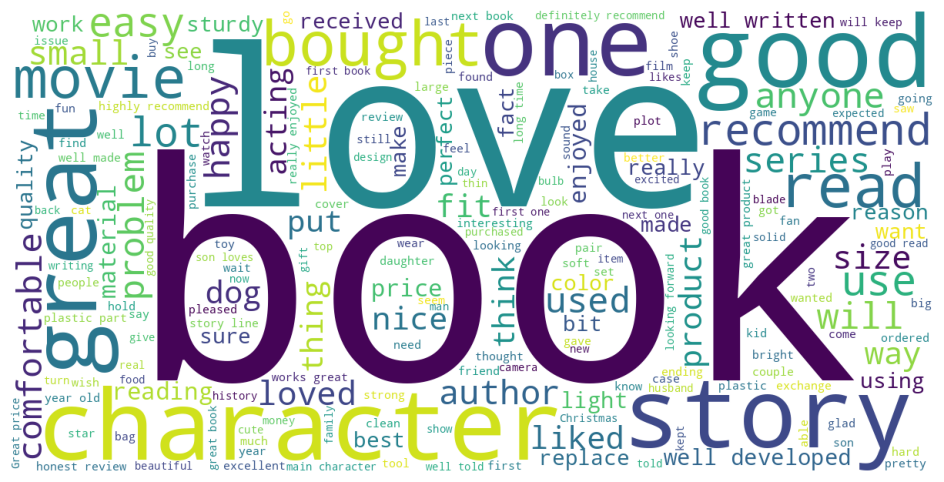

In [59]:
fake_texts = df[df['is_fake'] == 1]['text_']
all_words = " ".join(fake_texts)

wc = WordCloud(width=1200, height=600, background_color='white').generate(all_words)

plt.figure(figsize=(12,6))
plt.imshow(wc)
plt.axis('off')
plt.show()


Generate Word Cloud
